# **Homework 1 - Text Mining**

## Group Members:
1. **Tarang Kadyan**  
   <tarang.kadyan@bse.eu>

2. **Oriol Gelabert**  
   <oriol.gelabert@bse.eu>

3. **Enzo Infantes**  
   <enzo.infantes@bse.eu>

<img src='https://upload.wikimedia.org/wikipedia/commons/4/41/BSE_primary_logo_color.jpg' width=300 />

# **0. Libraries**

In [1]:
import os
import time

import pandas as pd
import numpy as np
import re

from packages.selenium_setup import *
from packages.scraper import BookingScraper
from packages.dataloading import DataCollection
from packages.processing import TextPreprocessor

# **1. Scraping**
This contains past preferences such as passwords, cookie acceptance etc.

Open **Booking.com** website to start our search. \
Note: In this step, we are using the functions from `selenium_setup.py` file.

In [2]:
dfolder= os.getcwd()
geko_path = os.path.join(dfolder, 'geckodriver.exe')
link='https://www.booking.com/index.es.html'

browser=start_up(dfolder=dfolder,link=link,geko_path=geko_path)

## **1.1 Booking Search**
In this section, we are using the `BookingScraper` class from `scraper.py`. Inside it, the following steps are performed:

- Reject cookies avoiding possible interference when scrapping.
- Google Log-in Pop-Up is inside an Iframe object. It must be closed.
- Define and search for our destination (city).
- Specify the month and the exact date (month and day).
- Click the search button.
- Genius pop-up might appear. It must be closed.
- **Important Step**: Now, we want to extract information from all hotels in Barcelona. The issue is that Booking initially displays only 25 hotels, and as you scroll down, it loads up to 75 before requiring a click on the 'Load More' button. To handle this, we create a function that scrolls to the bottom of the page (`scroll_and_click`), searches for this clickable button, and clicks it. This process runs in a while loop until the 'Load More' button is no longer available, indicating that all possible hotels have been displayed.

We are selecting the dates of the event we want to track, in our case MWC. This event is hosted between 3-6 March, so our initial serach will be on the week of 01 to 08 March.

In [3]:
scraper = BookingScraper(browser)
scraper.run_pipeline(place="Barcelona", 
                     target_month="marzo", 
                     target_year="2025",
                     from_date="03-01", 
                     to_date="03-08")

Message: Unable to locate element: /html/body/div[3]/div[2]/div/form/div/div[4]/button/span; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:197:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:527:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

Message: Unable to locate element: /html/body/div[3]/div[2]/div/form/div/div[4]/button/span; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:197:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.

## **1.2 Data Loading**
Now we have all the hotels loaded we will extract some information from them. After a quick inspection we identify several elements that could be usefull when analyzing an hotel:

* Hotel name : Can be used as an identifier
* Price : We can get the price of the stay for each hotel
* Rating: The feedback given by consumers of booking for each hotel
* Stars: We can also retrieve the number of stars of an hotel
* Distance to the center: This could indicate us if only central hotels are affected by an increase of prices.
* Neigbourhood: Maybe only certain neighbourhoods are affected by the presence of an event.
* Link: The link from booking for each hotel. 

**Note**: To extract all of these values we are using the function `get_hotel_information` from `dataloading.py` file.

There are some mismatches in the stars or ratings due to the same field format. Additionally, there are hotels without information about their rating or stars, and these will be considered as null values. To avoid this mismatch, we will access the container containing all properties for each hotel. Furthermore, we will extract the elements directly, not in their Selenium object format as done previously, but in a processed way. We use **RegEx** to extract the number of stars directly as an integer and also isolate the hotel Booking rating as a number. 

Finally, we use `requests` and `BeautifulSoup` to extract the description of each hotel, on this steps we also are using `ThreadPoolExecutor` to save time in this process. All these steps are available in the `dataloading.py` file.

In [4]:
data_collector = DataCollection(browser)
data = data_collector.get_all_hotel_data()

In [7]:
data.to_csv("Barcelona_MWC.csv", index=True, encoding='utf-8')
browser.close()

**Note**: This process must be executed four times according to the requirements. For each city (a total of two), we need to extract information about hotels during two different time periods (Part 3).

- **Milan**: We chose Milan as the second city to extract information because it has a similar population to Barcelona. Additionally, Milan is close to Spain and is a common destination for tourists too.

In [21]:
browser=start_up(dfolder=dfolder,link=link,geko_path=geko_path)

In [ ]:
scraper = BookingScraper(browser)
scraper.run_pipeline(place="Milan", 
                     target_month="marzo", 
                     target_year="2025",
                     from_date="03-01", 
                     to_date="03-08")

In [23]:
data_collector = DataCollection(browser)
data = data_collector.get_all_hotel_data()

In [24]:
data.to_csv("Milan_MWC.csv", index=True, encoding='utf-8')
browser.close()

# **2. Text analysis**

After extracting all the data about the hotels for our two cities, including their descriptions, we perform some pre-processing steps on our data.

## **2.1 Pre-process: stop words and stemming**

In [37]:
bcn = pd.read_csv("Barcelona_MWC.csv", index_col=0)
milan = pd.read_csv("Milan_MWC.csv", index_col=0)

# Define the preprocessing pipeline
extra_words = {"hotel", "habitacion", "huespedes", "ubicacion"}
preprocessor = TextPreprocessor(extra_stopwords=extra_words)

# Apply the preprocessing pipeline to the description column
bcn["processed_description"] = bcn["description"].apply(preprocessor.preprocess_text)
milan["processed_description"] = milan["description"].apply(preprocessor.preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Enzo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
bcn[['description', 'processed_description']].head()

,description,processed_description
0,"Isabella's House se encuentra a 2,9 km de Paseo de Gracia y ofrece alojamiento conrestaurante, b...",isabell hous encuentr km pase graci ofrec aloj conrestaur bar servici habit wifi gratis aloj alo...
1,"The Social Hub Barcelona Poblenou está en Barcelona, a 16 min a pie de Platja de Llevant, y disp...",the social hub barcelon poblenou barcelon min pie platj llevant dispon aloj piscin air libr park...
2,El BARCELONA GOTIC Guesthouse ocupa un edificio del siglo XIX situado en pleno centro histórico ...,barcelon gotic guesthous ocup edifici sigl xix situ plen centr histor barcelon sol minut pie ram...
3,"Este moderno hotel cuenta con 250 amplias y completamente equipadas habitaciones, un Snack-Bar a...",modern cuent ampli complet equip habit snackb abiert hor client pued disfrut desayun buffet asi ...
4,"El TWO Hotel Barcelona by Axel está situado en pleno barrio gay de Barcelona, a 2 km de la playa...",two barcelon by axel situ plen barri gay barcelon km play barcelonet alberg piscin azote solariu...


## **2.2 Wordclouds**

The preprocessed wordclouds show fewer irrelevant words, highlighting more meaningful terms like "beach," "modern," and "comfortable." Stemming reduces redundancy (e.g., "ubicación" → "ubicado"), improving clarity. This enhances interpretation and prepares the text for better analysis.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Enzo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


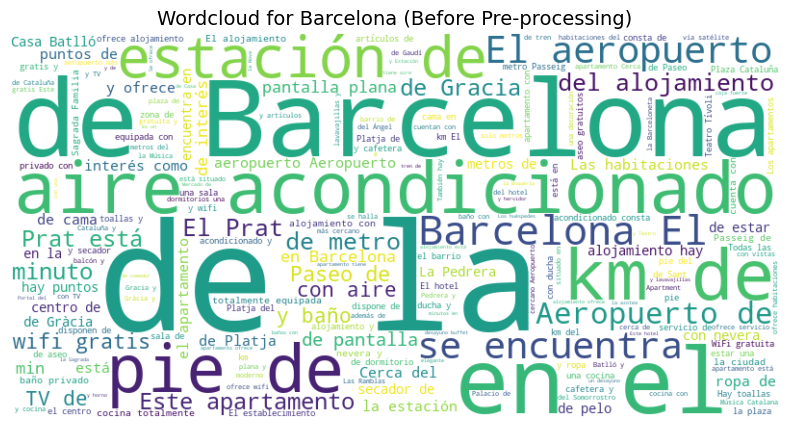

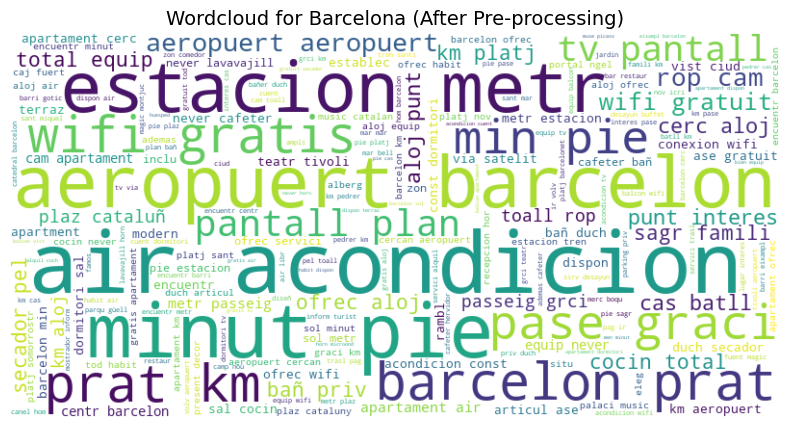

In [35]:
preprocessor.generate_wordcloud(bcn["description"], "Wordcloud for Barcelona (Before Pre-processing)")
preprocessor.generate_wordcloud(bcn["processed_description"], "Wordcloud for Barcelona (After Pre-processing)")

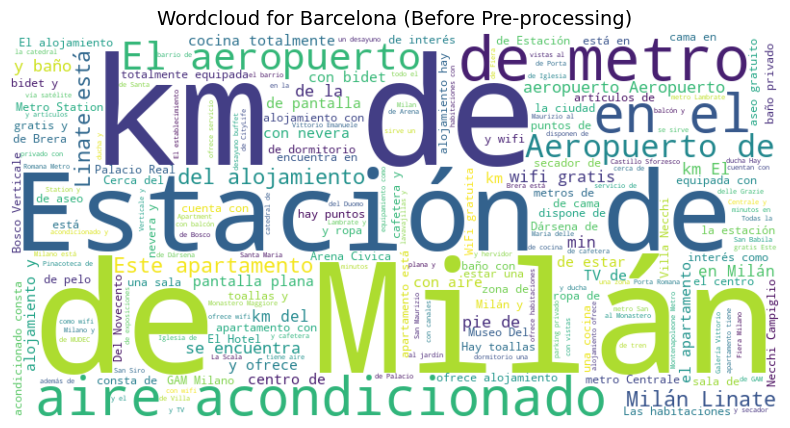

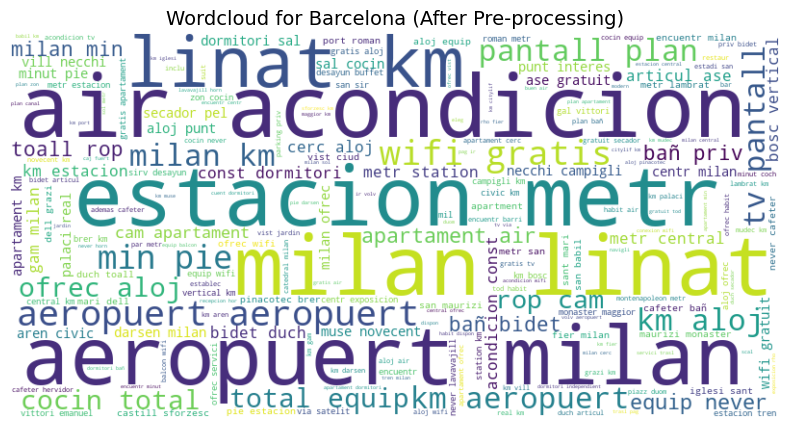

In [39]:
preprocessor.generate_wordcloud(milan["description"], "Wordcloud for Barcelona (Before Pre-processing)")
preprocessor.generate_wordcloud(milan["processed_description"], "Wordcloud for Barcelona (After Pre-processing)")